# Treinando a rede convolutiva

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import keras
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [0]:
!unzip dataset4.zip

In [0]:
train_dir = 'dataset4/train' 
validation_dir = 'dataset4/test' 

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
train_dir,
color_mode='grayscale',
target_size=(24, 16),
batch_size=1,
class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
color_mode='grayscale', 
target_size=(24, 16),
batch_size=1,
class_mode='categorical')

Found 220 images belonging to 5 classes.
Found 55 images belonging to 5 classes.


In [0]:
model = models.Sequential()

model.add(layers.Conv2D(20, (3, 3), activation='relu', padding='same', input_shape=(24, 16, 1)))
#model.add(layers.Conv2D(30, (3, 3), activation='relu', padding='same', input_shape=(240, 180, 1)))
model.add(layers.Conv2D(20, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(40, (3, 3),padding='same', activation='relu'))
model.add(layers.Conv2D(40, (3, 3),padding='same', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 24, 16, 20)        200       
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 22, 14, 20)        3620      
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 11, 7, 20)         0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 11, 7, 20)         0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 11, 7, 40)         7240      
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 11, 7, 40)         14440     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 5, 3, 40)          0         
__________

In [0]:
#opt = keras.optimizers.rmsprop(lr=0.000001)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
hist = model.fit_generator(
train_generator,
steps_per_epoch=220,
epochs=50,
validation_data=validation_generator,
validation_steps=55)


Epoch 1/50
220/220 [==============================] - 9s 41ms/step - loss: 1.8552 - acc: 0.1955 - val_loss: 1.6761 - val_acc: 0.1818
Epoch 2/50
220/220 [==============================] - 6s 26ms/step - loss: 1.5759 - acc: 0.3227 - val_loss: 1.3894 - val_acc: 0.4182
Epoch 3/50
220/220 [==============================] - 6s 26ms/step - loss: 1.2607 - acc: 0.5273 - val_loss: 0.9231 - val_acc: 0.5455
Epoch 4/50
220/220 [==============================] - 6s 26ms/step - loss: 1.0981 - acc: 0.6045 - val_loss: 0.9330 - val_acc: 0.6909
Epoch 5/50
220/220 [==============================] - 6s 26ms/step - loss: 0.9141 - acc: 0.7182 - val_loss: 0.5934 - val_acc: 0.7273
Epoch 6/50
220/220 [==============================] - 6s 29ms/step - loss: 0.8846 - acc: 0.7182 - val_loss: 0.6400 - val_acc: 0.8182
Epoch 7/50
220/220 [==============================] - 7s 30ms/step - loss: 0.8511 - acc: 0.7500 - val_loss: 0.6616 - val_acc: 0.7091
Epoch 8/50
220/220 [==============================] - 6s 26ms/step - 

In [0]:
def moving_average(sequence, n=2):
  
  new = []
  new.append(sequence[0])
  for i in np.arange(n-1, len(sequence)-n+1):
    
    new.append( (sequence[i-1] +  sequence[i]+ sequence[i+1])/3)
  
  return np.array(new)

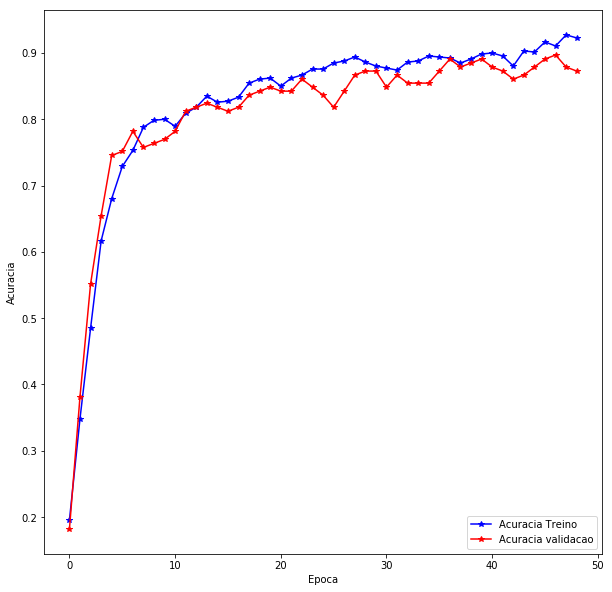

In [0]:
plt.rcParams['figure.figsize'] = 10, 10

acc = hist.history['acc']
acc_val = hist.history['val_acc']
ep = list(range(len(acc)))
plt.plot(ep[:49], moving_average(acc), '*-b', label='Acuracia Treino')
plt.plot(ep[:49], moving_average(acc_val), '*-r', label='Acuracia validacao')
plt.xlabel('Epoca')
plt.ylabel('Acuracia')
plt.legend(loc=4)
plt.savefig('Q4_acc_100.png')

In [0]:
model.save("Q4_trained.h5")

# Avaliando a rede com imagens rotacionadas e com ruído

###Setup (Rodar esses comandos apenas uma vez)

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import keras
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [0]:
!unzip dataset4.zip

In [0]:
!mkdir rotated_dataset

In [0]:
!mkdir noise_dataset

In [0]:
!mkdir noise_and_rotated

In [0]:
rede_loaded = models.load_model("Q4_trained.h5")

In [0]:
classes = np.array(["A", "E", "I", "O", "U"])

In [0]:
validation_dir = 'dataset4/test' 

In [0]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #print(y_true.shape)
    #print(y_pred.shape)
    classes = classes[unique_labels(y_true, y_pred).astype(int)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontweight='bold', fontsize=15)
    
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Label', fontsize=15)
    ax.set_ylabel('Label verdadeiro', fontsize=15)
    ax.set_title(title, fontsize=15)
    fig.tight_layout()
    return ax


###Dataset sem alterações (validação)



In [60]:
validation_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=0,
fill_mode='nearest'
)

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
color_mode='grayscale', 
target_size=(24, 16),
batch_size=55,
class_mode='categorical',
shuffle = False
)

Found 55 images belonging to 5 classes.


####Acurácia (Evaluate)

In [61]:
loss, acc = rede_loaded.evaluate_generator(validation_generator,steps=1,verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

1/1 [==============================] - 1s 1s/step
Test loss: 0.6814412474632263
Test accuracy: 0.8363636136054993


####Matriz de Confusão (Predict)

Confusion matrix, without normalization
[[11  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  1  8  2  0]
 [ 1  1  0  9  0]
 [ 3  0  1  0  7]]


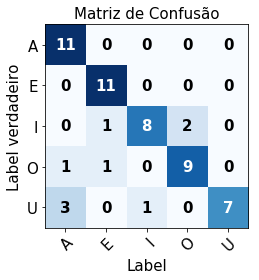

In [62]:
prediction = rede_loaded.predict_generator(validation_generator,steps=1,verbose=0)

pred_ind = [np.argmax(i) for i in prediction]

# print(confusion_matrix(validation_generator.classes, pred_ind))

plot_confusion_matrix(validation_generator.classes, pred_ind, classes=classes, title='Matriz de Confusão')
plt.savefig("fig_4_confMatrix_sem_alteracao.png", dpi=320)
plt.show()

### Dataset com rotação

In [63]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
color_mode='grayscale', 
target_size=(24, 16),
batch_size=55,
class_mode='categorical',
save_to_dir='rotated_dataset',
save_prefix='rotated_',
shuffle = False,
seed=73)

Found 55 images belonging to 5 classes.


#### Acurácia (Evaluate)

In [64]:
loss, acc = rede_loaded.evaluate_generator(validation_generator,steps=1,verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

1/1 [==============================] - 1s 1s/step
Test loss: 1.5805528163909912
Test accuracy: 0.5272727012634277


####Matriz de Confusão (Predict)

Confusion matrix, without normalization
[[ 3  2  4  0  2]
 [ 0  5  5  0  1]
 [ 0  0 11  0  0]
 [ 0  1  3  7  0]
 [ 0  1  4  0  6]]


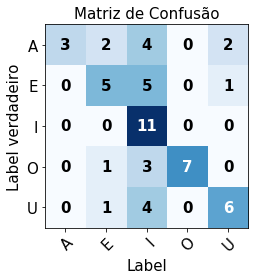

In [65]:
prediction = rede_loaded.predict_generator(validation_generator,steps=1,verbose=0)

pred_ind = [np.argmax(i) for i in prediction]

# print(confusion_matrix(validation_generator.classes, pred_ind))

plot_confusion_matrix(validation_generator.classes, pred_ind, classes=classes, title='Matriz de Confusão')
plt.savefig("fig_4_confMatrix_rotacao.png", dpi=320)
plt.show()

### Dataset com ruido

In [0]:
def salt_and_pepper(image):
  chance = np.random.randint(99,size=image.shape)
  noise = np.random.random_sample(size=image.shape)
  final = np.where(chance < 5, noise, image)
  return final

In [67]:
validation_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=0,
fill_mode='nearest',
preprocessing_function=salt_and_pepper)

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
color_mode='grayscale', 
target_size=(24, 16),
batch_size=55,
class_mode='categorical',
save_to_dir='noise_dataset',
save_prefix='noise_',
shuffle = False,
seed=42)


Found 55 images belonging to 5 classes.


####Acurácia (Evaluate)

In [68]:
loss, acc = rede_loaded.evaluate_generator(validation_generator,steps=1,verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

1/1 [==============================] - 1s 1s/step
Test loss: 1.6963285207748413
Test accuracy: 0.6909090876579285


####Matriz de Confusão (Predict)

Confusion matrix, without normalization
[[10  1  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0  8  2  1]
 [ 0  2  0  9  0]
 [ 3  1  0  1  6]]


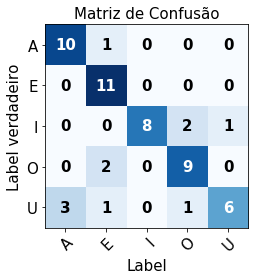

In [69]:
prediction = rede_loaded.predict_generator(validation_generator,steps=1,verbose=0)

pred_ind = [np.argmax(i) for i in prediction]

# print(confusion_matrix(validation_generator.classes, pred_ind))

plot_confusion_matrix(validation_generator.classes, pred_ind, classes=classes, title='Matriz de Confusão')
plt.savefig("fig_4_confMatrix_ruido.png", dpi=320)
plt.show()

###Dataset com rotação e ruído

In [70]:
validation_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=60,
fill_mode='nearest',
preprocessing_function=salt_and_pepper)

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
color_mode='grayscale', 
target_size=(24, 16),
batch_size=55,
class_mode='categorical',
save_to_dir='noise_and_rotated',
save_prefix='noise_rotated_',
shuffle=False,
seed = 42069
)

Found 55 images belonging to 5 classes.


####Acurácia (Evaluate)

In [71]:
loss, acc = rede_loaded.evaluate_generator(validation_generator,steps=1,verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

1/1 [==============================] - 1s 1s/step
Test loss: 2.1945862770080566
Test accuracy: 0.4545454680919647


####Matriz de Confusão (Predict)

Confusion matrix, without normalization
[[3 5 3 0 0]
 [0 7 4 0 0]
 [0 4 7 0 0]
 [0 5 2 4 0]
 [0 4 3 0 4]]


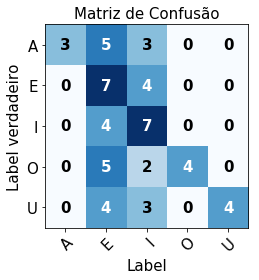

In [72]:
prediction = rede_loaded.predict_generator(validation_generator,steps=1,verbose=0)

pred_ind = [np.argmax(i) for i in prediction]

# print(confusion_matrix(validation_generator.classes, pred_ind))

plot_confusion_matrix(validation_generator.classes, pred_ind, classes=classes, title='Matriz de Confusão')
plt.savefig("fig_4_confMatrix_rotacao_ruido.png", dpi=320)
plt.show()

#Testes 

####Teste do ruído

In [0]:
# def test_noise(image):
#   chance = np.random.randint(99,size=image.shape)
#   noise = np.random.random_sample(size=image.shape)
#   final = np.where(chance < 5, noise, image)
#   return final
  

In [0]:
# !mkdir noise_test_normal

In [0]:
# validation_dir = 'dataset4/test' 

# validation_datagen = ImageDataGenerator(
# rescale=1./255,
# rotation_range=0,
# fill_mode='nearest',
# preprocessing_function=test_noise)

# validation_generator = validation_datagen.flow_from_directory(
# validation_dir,
# color_mode='grayscale', 
# target_size=(24, 16),
# batch_size=55,
# class_mode='categorical',
# save_to_dir='noise_test_normal',
# save_prefix='noiseTest')


Found 55 images belonging to 5 classes.


In [0]:
# loss, acc = rede_loaded.evaluate_generator(validation_generator,steps=1,verbose=1)
# print('Test loss:', loss)
# print('Test accuracy:', acc)

1/1 [==============================] - 1s 1s/step
Test loss: 1.9270159006118774
Test accuracy: 0.6181818246841431


####Teste exibir imagens

In [0]:
from keras.preprocessing import image
import matplotlib.cm as cm

img_path = 'dataset4/test/a/img011-045.png'

img = image.load_img(img_path, target_size=(600, 450),color_mode='grayscale')

img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)


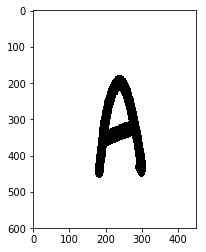

In [119]:
normal_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    fill_mode='nearest')

i=0
for batch in normal_datagen.flow(img_array,batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i+=1
  if i == 1:
      break
    
plt.show()

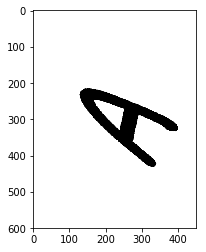

In [128]:
rotation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    fill_mode='nearest')

i=0
for batch in rotation_datagen.flow(img_array,batch_size=1,seed=42069):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i+=1
  if i == 1:
      break
    
plt.show()

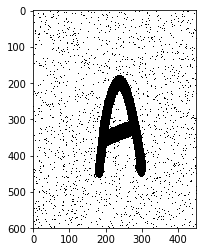

In [110]:
noise_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    fill_mode='nearest',
    preprocessing_function=salt_and_pepper)

i=0
for batch in noise_datagen.flow(img_array,batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i+=1
  if i == 1:
      break
    
plt.show()

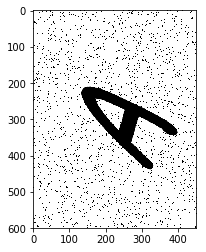

In [130]:
rotation_noise_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    fill_mode='nearest',
    preprocessing_function=salt_and_pepper)

i=0
for batch in rotation_noise_datagen.flow(img_array,batch_size=1,seed=7373):
  plt.figure(i)

  imgplot = plt.imshow(image.array_to_img(batch[0]), cmap='gray')
  i+=1
  if i == 1:
      break
plt.show()